In [1]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
dim = 512 
fold = 4

In [3]:
# train_df = pd.read_csv(f'../input/vinbigdata-{dim}-image-dataset/vinbigdata/train.csv')
train_df = pd.read_csv(f'../input/train-90-10-split/new_df_90.csv')
train_df.head()

image_id  class_name  class_id rad_id  x_min  \
0  000434271f63a053c4128a0ba6352c7f  No finding        14     R6    NaN   
1  000434271f63a053c4128a0ba6352c7f  No finding        14     R2    NaN   
2  000434271f63a053c4128a0ba6352c7f  No finding        14     R3    NaN   
3  00053190460d56c53cc3e57321387478  No finding        14    R11    NaN   
4  00053190460d56c53cc3e57321387478  No finding        14     R2    NaN   

   y_min  x_max  y_max  width  height  
0    NaN    NaN    NaN   2336    2836  
1    NaN    NaN    NaN   2336    2836  
2    NaN    NaN    NaN   2336    2836  
3    NaN    NaN    NaN   1994    2430  
4    NaN    NaN    NaN   1994    2430

In [4]:
# creating a new col containing full image path
train_df['image_path'] = f'/kaggle/input/vinbigdata-{dim}-image-dataset/vinbigdata/train/'+train_df.image_id+('.png' if dim!='original' else '.jpg')
train_df.head()

image_id  class_name  class_id rad_id  x_min  \
0  000434271f63a053c4128a0ba6352c7f  No finding        14     R6    NaN   
1  000434271f63a053c4128a0ba6352c7f  No finding        14     R2    NaN   
2  000434271f63a053c4128a0ba6352c7f  No finding        14     R3    NaN   
3  00053190460d56c53cc3e57321387478  No finding        14    R11    NaN   
4  00053190460d56c53cc3e57321387478  No finding        14     R2    NaN   

   y_min  x_max  y_max  width  height  \
0    NaN    NaN    NaN   2336    2836   
1    NaN    NaN    NaN   2336    2836   
2    NaN    NaN    NaN   2336    2836   
3    NaN    NaN    NaN   1994    2430   
4    NaN    NaN    NaN   1994    2430   

                                          image_path  
0  /kaggle/input/vinbigdata-512-image-dataset/vin...  
1  /kaggle/input/vinbigdata-512-image-dataset/vin...  
2  /kaggle/input/vinbigdata-512-image-dataset/vin...  
3  /kaggle/input/vinbigdata-512-image-dataset/vin...  
4  /kaggle/input/vinbigdata-512-image-dataset/vin...

# Choosing only 14 Classes

In [5]:
train_df = train_df[train_df.class_id!=14].reset_index(drop = True)

# Pre-Processing

In [6]:
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

# w & h of BB
train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df['area'] = train_df['w']*train_df['h']
train_df.head()

image_id     class_name  class_id rad_id     x_min  \
0  0005e8e3701dfb1dd93d53e2ff537b6e   Lung Opacity         7    R10  0.292969   
1  0005e8e3701dfb1dd93d53e2ff537b6e    Nodule/Mass         8     R8  0.303385   
2  0005e8e3701dfb1dd93d53e2ff537b6e   Infiltration         6    R10  0.292969   
3  0005e8e3701dfb1dd93d53e2ff537b6e   Lung Opacity         7     R9  0.294596   
4  0005e8e3701dfb1dd93d53e2ff537b6e  Consolidation         4     R8  0.303385   

      y_min     x_max     y_max  width  height  \
0  0.191081  0.392253  0.289062   3072    3072   
1  0.184570  0.389648  0.291667   3072    3072   
2  0.191081  0.392253  0.289062   3072    3072   
3  0.189779  0.391602  0.289714   3072    3072   
4  0.184570  0.389648  0.291667   3072    3072   

                                          image_path     x_mid     y_mid  \
0  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.342611  0.240072   
1  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.346517  0.238118   
2  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.342611  0.240072   
3  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.343099  0.239746   
4  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.346517  0.238118   

          w         h      area  
0  0.099284  0.097982  0.009728  
1  0.086263  0.107096  0.009238  
2  0.099284  0.097982  0.009728  
3  0.097005  0.099935  0.009694  
4  0.086263  0.107096  0.009238

In [7]:
features = ['x_min', 'y_min', 'x_max', 'y_max', 'x_mid', 'y_mid', 'w', 'h', 'area']
X = train_df[features]
y = train_df['class_id']
X.shape, y.shape

((32604, 9), (32604,))

In [8]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

# K- fold validation Split

In [9]:
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

image_id     class_name  class_id rad_id     x_min  \
0  0005e8e3701dfb1dd93d53e2ff537b6e   Lung Opacity         7    R10  0.292969   
1  0005e8e3701dfb1dd93d53e2ff537b6e    Nodule/Mass         8     R8  0.303385   
2  0005e8e3701dfb1dd93d53e2ff537b6e   Infiltration         6    R10  0.292969   
3  0005e8e3701dfb1dd93d53e2ff537b6e   Lung Opacity         7     R9  0.294596   
4  0005e8e3701dfb1dd93d53e2ff537b6e  Consolidation         4     R8  0.303385   

      y_min     x_max     y_max  width  height  \
0  0.191081  0.392253  0.289062   3072    3072   
1  0.184570  0.389648  0.291667   3072    3072   
2  0.191081  0.392253  0.289062   3072    3072   
3  0.189779  0.391602  0.289714   3072    3072   
4  0.184570  0.389648  0.291667   3072    3072   

                                          image_path     x_mid     y_mid  \
0  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.342611  0.240072   
1  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.346517  0.238118   
2  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.342611  0.240072   
3  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.343099  0.239746   
4  /kaggle/input/vinbigdata-512-image-dataset/vin...  0.346517  0.238118   

          w         h      area  fold  
0  0.099284  0.097982  0.009728     2  
1  0.086263  0.107096  0.009238     2  
2  0.099284  0.097982  0.009728     2  
3  0.097005  0.099935  0.009694     2  
4  0.086263  0.107096  0.009238     2

In [10]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())
len(train_files), len(val_files)

(3156, 789)

In [11]:
train_files[0]

'/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/train/0005e8e3701dfb1dd93d53e2ff537b6e.png'

# Copying Files

In [12]:
os.makedirs('/kaggle/working/vinbigdata/labels/train', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/labels/val', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/images/train', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/images/val', exist_ok = True)
label_dir = '/kaggle/input/vinbigdata-yolo-labels-dataset/labels'
for file in tqdm(train_files):
    shutil.copy(file, '/kaggle/working/vinbigdata/images/train')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/kaggle/working/vinbigdata/labels/train')
    
for file in tqdm(val_files):
    shutil.copy(file, '/kaggle/working/vinbigdata/images/val')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/kaggle/working/vinbigdata/labels/val')

  0%|          | 0/3156 [00:00<?, ?it/s]

  0%|          | 0/789 [00:00<?, ?it/s]

# Get Class Name

In [13]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

# YOLOv5

In [14]:
from os import listdir
from os.path import isfile, join
import yaml

cwd = '/kaggle/working/'

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob('/kaggle/working/vinbigdata/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob('/kaggle/working/vinbigdata/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 14,
    names = classes
    )

with open(join( cwd , 'vinbigdata.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'vinbigdata.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: /kaggle/working/train.txt
val: /kaggle/working/val.txt



In [15]:
!head /kaggle/working/train.txt

/kaggle/working/vinbigdata/images/train/1b420f79b18aeb2c7644d4998d313f37.png
/kaggle/working/vinbigdata/images/train/b73e16e580992f545e375c2d3d6f7387.png
/kaggle/working/vinbigdata/images/train/c65efe41cef6390d70796a2947dbcc91.png
/kaggle/working/vinbigdata/images/train/eb319a3149253e25a32a6f2926cf67b2.png
/kaggle/working/vinbigdata/images/train/285c4b227a6c923d674fa58fdfdd2eca.png
/kaggle/working/vinbigdata/images/train/bd931b74386e3e3f2934b1741c77d5b1.png
/kaggle/working/vinbigdata/images/train/9fa07ce40365c2c37f75ba3a5486b8c6.png
/kaggle/working/vinbigdata/images/train/3e8719d1ba69b36c24ad3e39a8dd83ed.png
/kaggle/working/vinbigdata/images/train/25f0621dae8874aac9985c4034a565ea.png
/kaggle/working/vinbigdata/images/train/9a080db6a1a2ceca36947cebd0367514.png


In [16]:
# https://www.kaggle.com/ultralytics/yolov5
# !git clone https://github.com/ultralytics/yolov5  # clone repo
# %cd yolov5

shutil.copytree('/kaggle/input/yolov5-official-v31-dataset/yolov5', '/kaggle/working/yolov5')
os.chdir('/kaggle/working/yolov5')
# %pip install -qr requirements.txt # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Train Model

In [17]:
# !WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 3 --data coco128.yaml --weights yolov5s.pt --nosave --cache 
!WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 30 --data /kaggle/working/vinbigdata.yaml --weights yolov5x.pt --cache

2021-03-26 02:00:38.784286: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
100%|████████████████████████████████████████| 170M/170M [00:05<00:00, 33.9MB/s]

2021-03-26 02:00:57.463622: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2021-03-26 02:00:57.466276: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
wandb: Offline run mode, not syncing to the cloud.
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` to enable cloud syncing.
Scanning '/kaggle/working/vinbigdata/labels/train' for images and labels... 3156 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 3156/3156 [00:02<00:00, 1451.09it/s]
Scanning '/kaggle/working/vinbigdata/labels/train.cache' for images and labels... 3156 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 3156/31

# GT Vs Pred

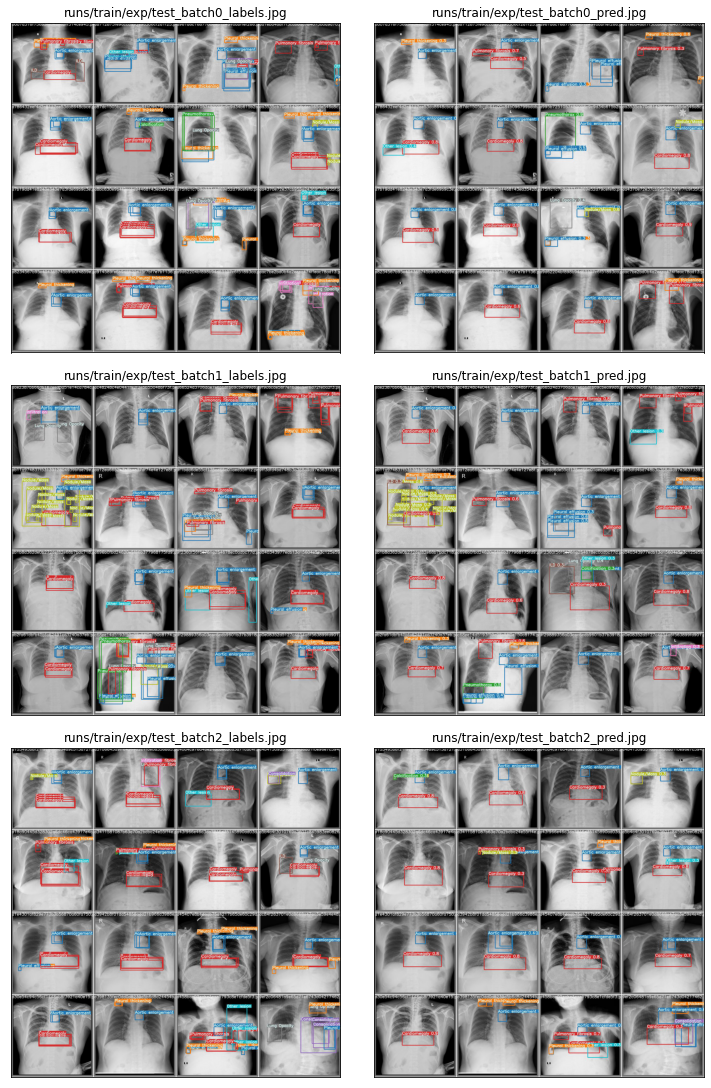

In [18]:
fig, ax = plt.subplots(3, 2, figsize = (2*5,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'runs/train/exp/test_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'runs/train/exp/test_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'runs/train/exp/test_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'runs/train/exp/test_batch{row}_pred.jpg', fontsize = 12)

# (Loss, Map) Vs Epoch

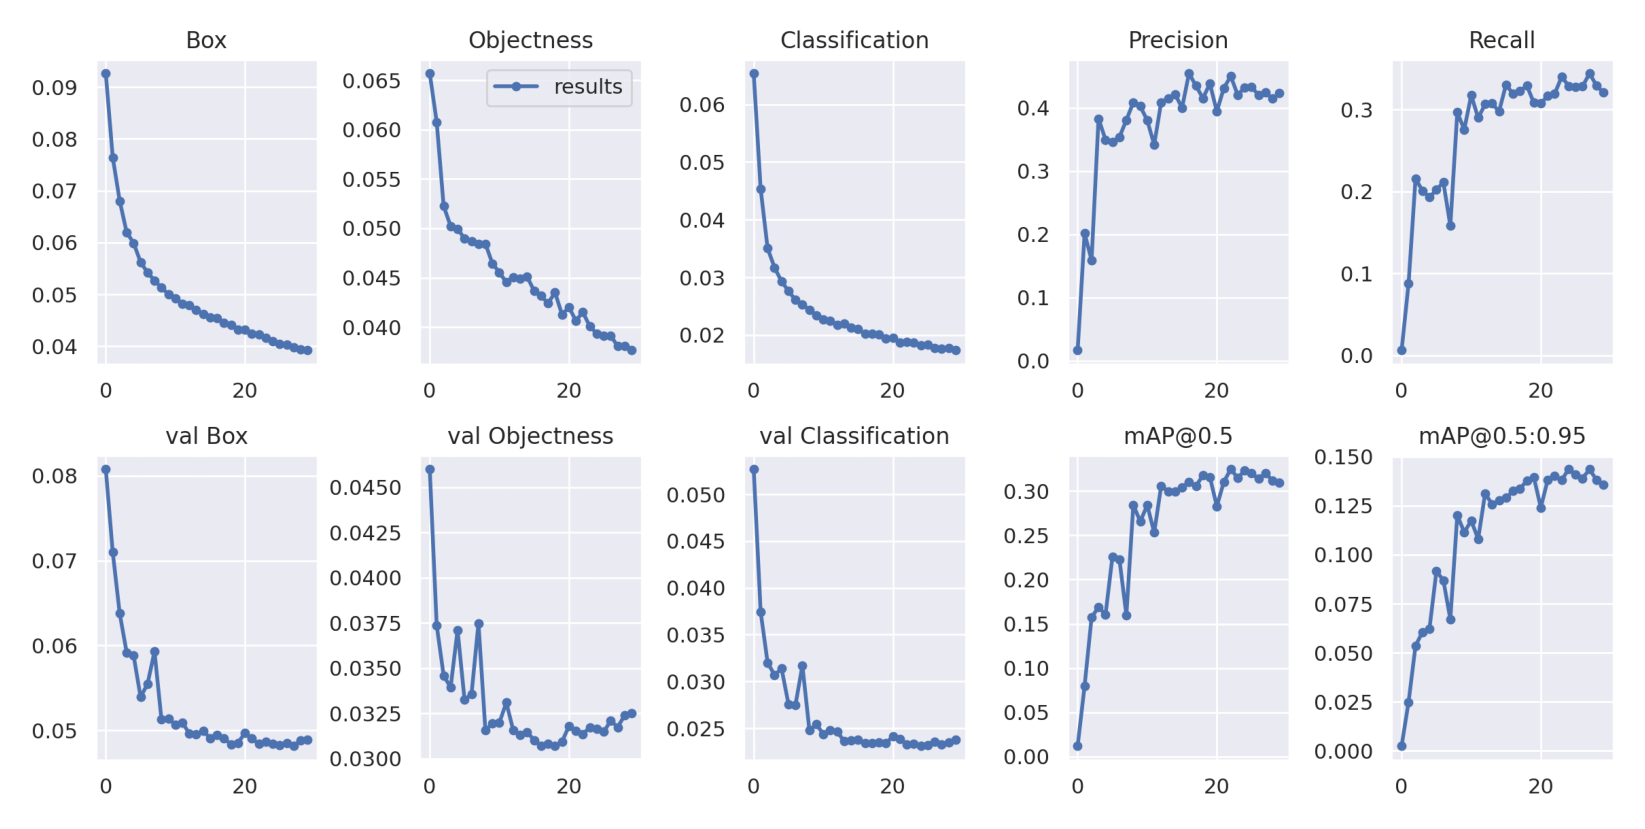

In [19]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/results.png'));

# Confusion Matrix

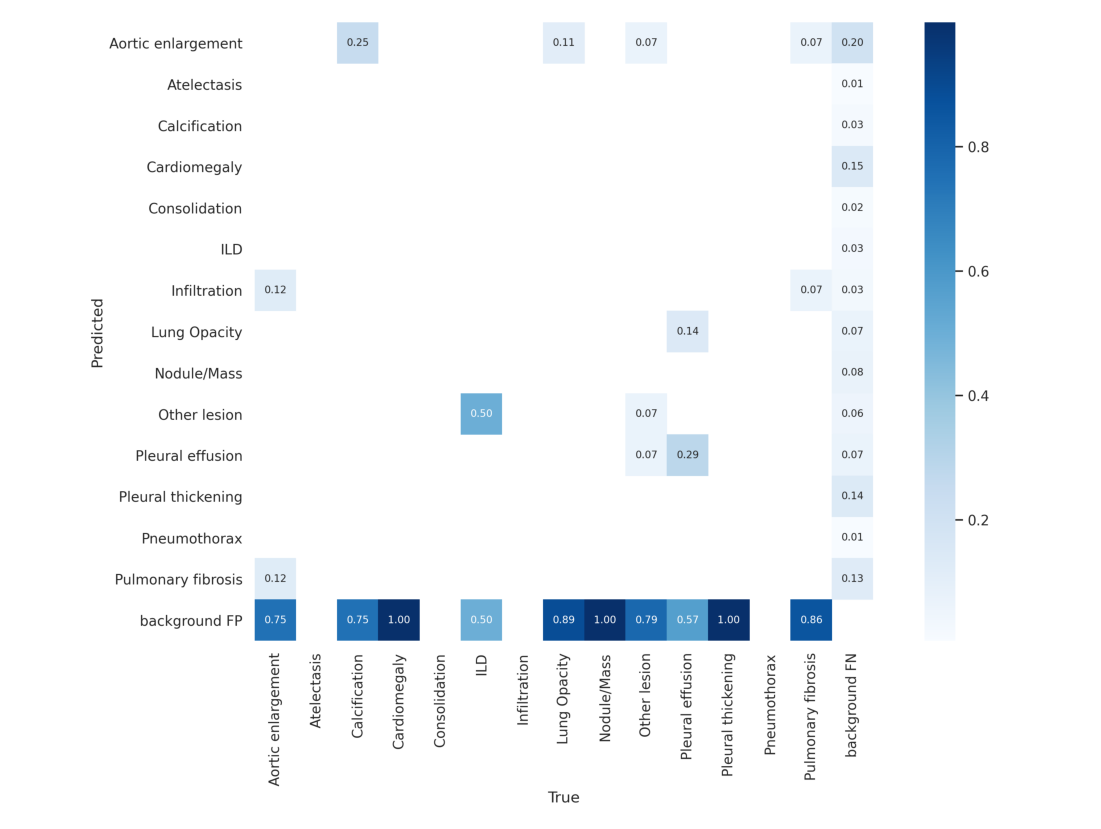

In [20]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'));

# Inference

In [21]:
!python detect.py --weights 'runs/train/exp/weights/best.pt'\
--img 640\
--conf 0.15\
--iou 0.5\
--source /kaggle/working/vinbigdata/images/val\
--exist-ok

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.15, device='', exist_ok=True, img_size=640, iou_thres=0.5, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/kaggle/working/vinbigdata/images/val', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
Fusing layers... 
image 1/789 /kaggle/working/vinbigdata/images/val/0007d316f756b3fa0baea2ff514ce945.png: 640x640 1 Aortic enlargements, 3 Pleural thickenings, 1 Pulmonary fibrosiss, Done. (0.049s)
image 2/789 /kaggle/working/vinbigdata/images/val/00f2f97f74e086e1f82acc285ee4a5c5.png: 640x640 1 Aortic enlargements, 1 Cardiomegalys, 3 Pleural thickenings, Done. (0.049s)
image 3/789 /kaggle/working/vinbigdata/images/val/010a3dbb67bc37800a041866844861b1.png: 640x640 1 Aortic enlargements, 1 Cardiomegalys, 2 ILDs, 1 Pleural thickenings, 1 Pulmonary fibrosiss, Done. (0.048s)
image 4/789 /kaggle/working/vinbigdata/images/val/0114c5cd093c742334d5a5fa14140421.png: 640x640 1 Aort

# Inference Plot

100%|██████████| 16/16 [00:00<00:00, 133.95it/s]


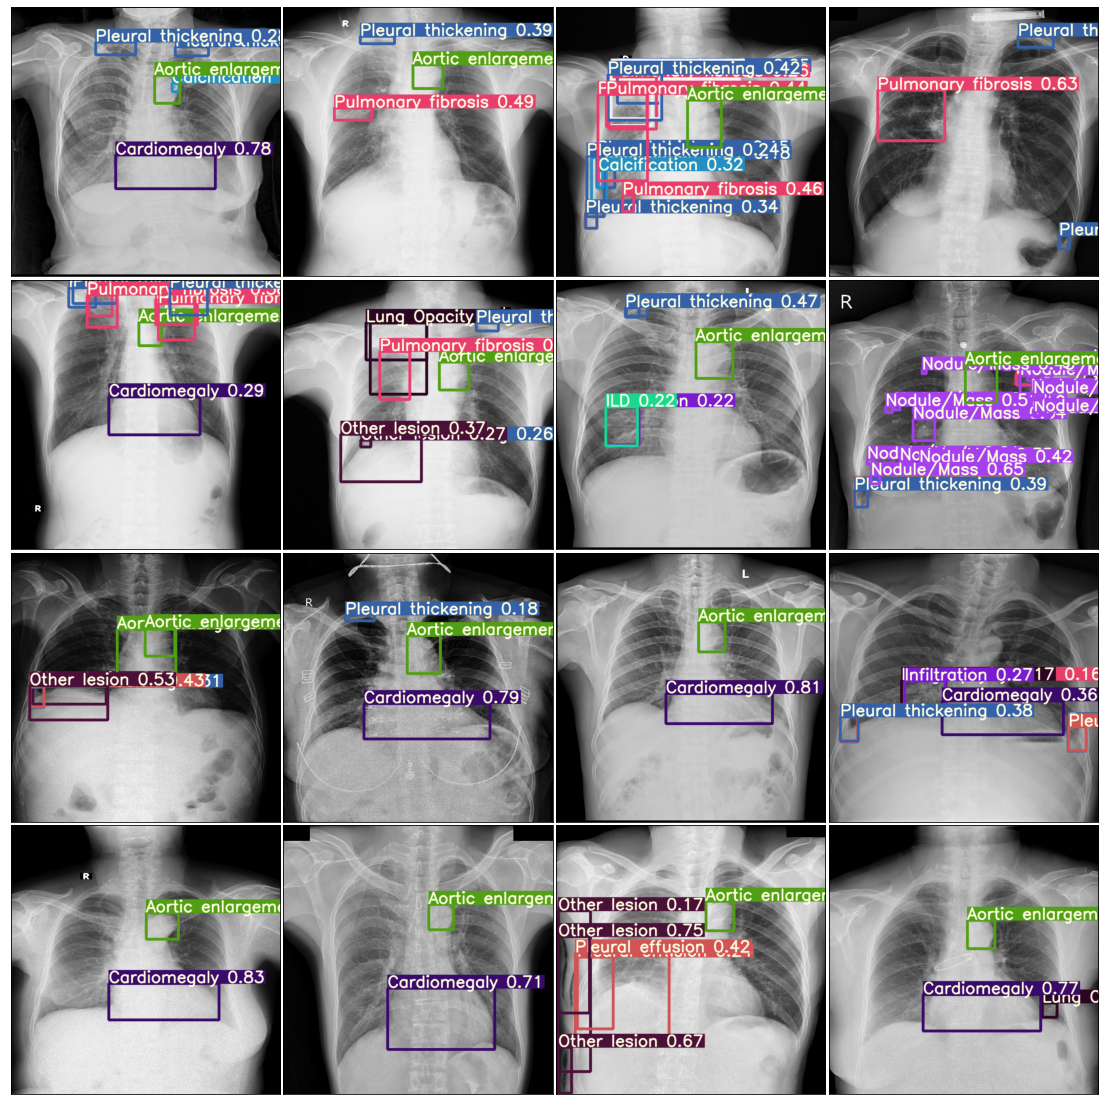

100%|██████████| 16/16 [00:00<00:00, 123.97it/s]


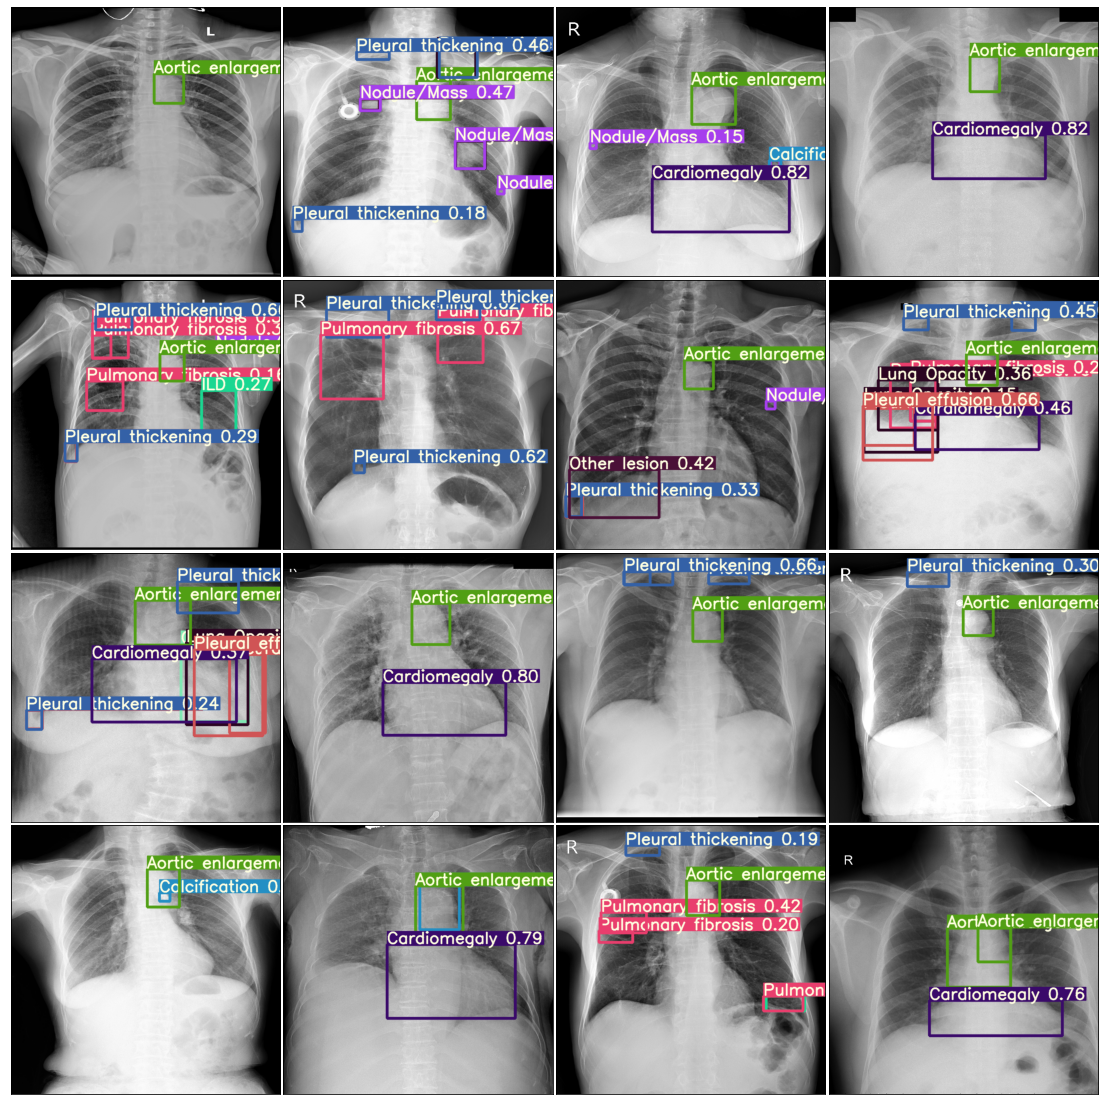

100%|██████████| 16/16 [00:00<00:00, 119.95it/s]


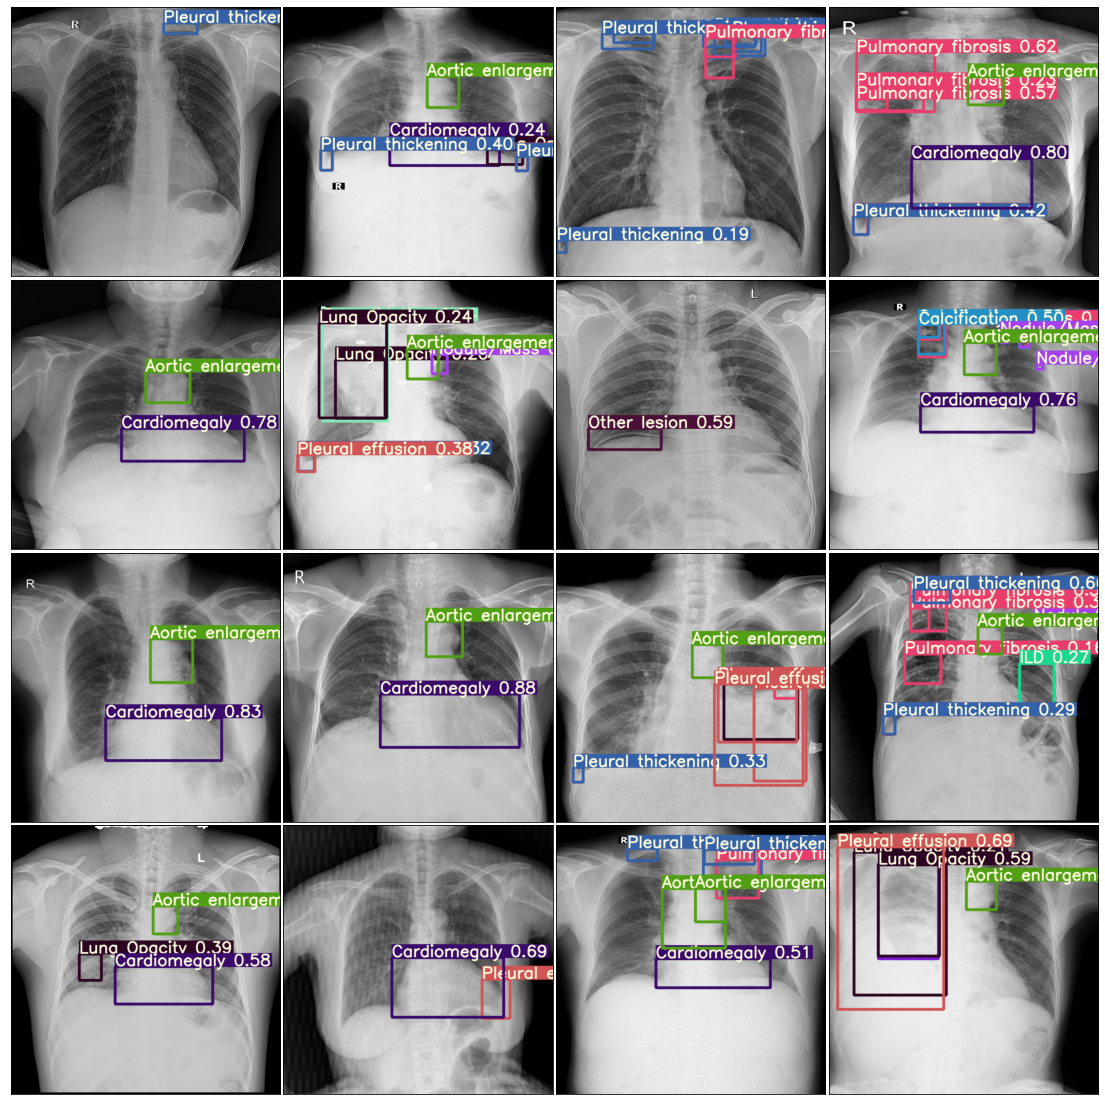

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import cv2
from glob import glob
from tqdm import tqdm

files = glob('runs/detect/exp/*')
for _ in range(3):
    row = 4
    col = 4
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img          = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [23]:
shutil.rmtree('/kaggle/working/vinbigdata')
shutil.rmtree('runs/detect')
for file in (glob('runs/train/exp/**/*.png', recursive = True)+glob('runs/train/exp/**/*.jpg', recursive = True)):
    os.remove(file)